In [3]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdown

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

In [5]:
!gdown 1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0

Downloading...
From (original): https://drive.google.com/uc?id=1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0
From (redirected): https://drive.google.com/uc?id=1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0&confirm=t&uuid=68b431ba-f798-46dc-904b-6bf931f28e9c
To: /content/img_cls_weather_dataset.zip
100% 613M/613M [00:10<00:00, 61.1MB/s]


In [6]:
!unzip /content/img_cls_weather_dataset.zip -d /content/weather-dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/weather-dataset/weather-dataset/dataset/frost/3922.jpg  
  inflating: /content/weather-dataset/weather-dataset/dataset/frost/3923.jpg  
  inflating: /content/weather-dataset/weather-dataset/dataset/frost/3924.jpg  
  inflating: /content/weather-dataset/weather-dataset/dataset/frost/3925.jpg  
  inflating: /content/weather-dataset/weather-dataset/dataset/frost/3926.jpg  
  inflating: /content/weather-dataset/weather-dataset/dataset/frost/3927.jpg  
  inflating: /content/weather-dataset/weather-dataset/dataset/frost/3928.jpg  
  inflating: /content/weather-dataset/weather-dataset/dataset/frost/3929.jpg  
  inflating: /content/weather-dataset/weather-dataset/dataset/frost/3930.jpg  
  inflating: /content/weather-dataset/weather-dataset/dataset/frost/3931.jpg  
  inflating: /content/weather-dataset/weather-dataset/dataset/frost/3932.jpg  
  inflating: /content/weather-dataset/weather-dataset/dataset/frost/3933.jpg  
 

In [7]:
root_dir = '/content/weather-dataset/weather-dataset/dataset'
img_paths = []
labels = []
classes = {
    label_idx: class_name for label_idx, class_name in enumerate(sorted(os.listdir(root_dir)))
}
for label_idx, class_name in classes.items():
    class_dir = os.path.join(root_dir, class_name)
    for img_filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_filename)
        img_paths.append(img_path)
        labels.append(label_idx)

In [8]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size = val_size,
    random_state = seed,
    shuffle = is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size = test_size,
    random_state = seed,
    shuffle = is_shuffle
)

In [9]:
class WeatherDataset(Dataset):
    def __init__(
            self,
            X,
            y,
            transform=None
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]

In [10]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)[..., :3]
    img = torch.tensor(img).permute(2, 0, 1).float()
    normalized_img = img / 255.0

    return normalized_img

In [11]:
train_dataset = WeatherDataset(
    X_train, y_train,
    transform=transform
)
val_dataset = WeatherDataset(
    X_val, y_val,
    transform=transform
)
test_dataset = WeatherDataset(
    X_test, y_test,
    transform=transform
)

In [12]:
train_batch_size = 512
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=stride,
            padding=1
        )
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=1,
                    stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = x.clone()
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x += self.downsample(shortcut)
        x = self.relu(x)

        return x

In [14]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_blocks_list, n_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3
        )
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1
        )
        self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_list[0], 1)
        self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_list[1], 2)
        self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_list[2], 2)
        self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_list[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, n_classes)

    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(
            in_channels,
            out_channels,
            stride
        )
        blocks.append(first_block)

        for idx in range(1, n_blocks):
            block = residual_block(
                in_channels=out_channels,
                out_channels=out_channels,
                stride=1
            )
            blocks.append(block)

        block_sequential = nn.Sequential(*blocks)
        return block_sequential

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)

        return x

In [15]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_list=[2, 2, 2, 2],
    n_classes=n_classes
).to(device)

In [16]:
def evaluate(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    correct = 0   # Initialize counter for correct predictions
    total = 0     # Initialize counter for total predictions
    losses = []   # Initialize list to store batch losses
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in dataloader:  # Iterate through batches
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
            outputs = model(inputs)  # Get model predictions
            loss = criterion(outputs, labels)  # Calculate loss
            losses.append(loss.item())  # Store batch loss
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class indices
            total += labels.size(0)  # Add batch size to total
            correct += (predicted == labels).sum().item()  # Count correct predictions

        loss = sum(losses) / len(losses)  # Calculate average loss
        acc = correct / total  # Calculate accuracy

        return loss, acc  # Return metrics

def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []  # Initialize list to store training losses
    val_losses = []    # Initialize list to store validation losses

    for epoch in range(epochs):  # Iterate through epochs
        batch_train_losses = []  # Initialize list for batch losses

        model.train()  # Set model to training mode
        for idx, (inputs, labels) in enumerate(train_loader):  # Iterate through batches
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
            optimizer.zero_grad()  # Reset gradients
            outputs = model(inputs)  # Get model predictions
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters

            batch_train_losses.append(loss.item())  # Store batch loss

        train_loss = sum(batch_train_losses) / len(batch_train_losses)  # Calculate average training loss
        train_losses.append(train_loss)  # Store epoch training loss

        val_loss, val_acc = evaluate(  # Evaluate on validation set
            model=model, dataloader=val_loader,
            criterion=criterion, device=device
        )
        val_losses.append(val_loss)  # Store validation loss

        print(f'EPOCH {epoch + 1}: Train loss: {train_loss: .4f} Val loss: {val_loss: .4f}')  # Print progress

    return train_losses, val_losses  # Return training history


In [17]:
lr = 1e-2
epochs = 25

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr
)

saved_models = '/content/model'
os.makedirs(saved_models, exist_ok=True)

In [18]:
train_losses, val_losses = fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=epochs
)

EPOCH 1: Train loss:  1.8990 Val loss:  2.3821
EPOCH 2: Train loss:  1.3888 Val loss:  2.6042
EPOCH 3: Train loss:  1.2320 Val loss:  2.7577
EPOCH 4: Train loss:  1.1399 Val loss:  1.8838
EPOCH 5: Train loss:  1.0678 Val loss:  1.3289
EPOCH 6: Train loss:  1.0240 Val loss:  1.4354
EPOCH 7: Train loss:  0.9797 Val loss:  1.4626
EPOCH 8: Train loss:  0.9322 Val loss:  2.4036
EPOCH 9: Train loss:  0.8915 Val loss:  2.5464
EPOCH 10: Train loss:  0.8908 Val loss:  1.3800
EPOCH 11: Train loss:  0.8529 Val loss:  1.2292
EPOCH 12: Train loss:  0.7979 Val loss:  2.1895
EPOCH 13: Train loss:  0.7883 Val loss:  1.6023
EPOCH 14: Train loss:  0.7613 Val loss:  1.4110
EPOCH 15: Train loss:  0.7240 Val loss:  1.2401
EPOCH 16: Train loss:  0.7105 Val loss:  1.9824
EPOCH 17: Train loss:  0.6913 Val loss:  1.3974
EPOCH 18: Train loss:  0.6464 Val loss:  1.1124
EPOCH 19: Train loss:  0.6355 Val loss:  1.3294
EPOCH 20: Train loss:  0.6056 Val loss:  1.2022
EPOCH 21: Train loss:  0.5892 Val loss:  1.5476
E

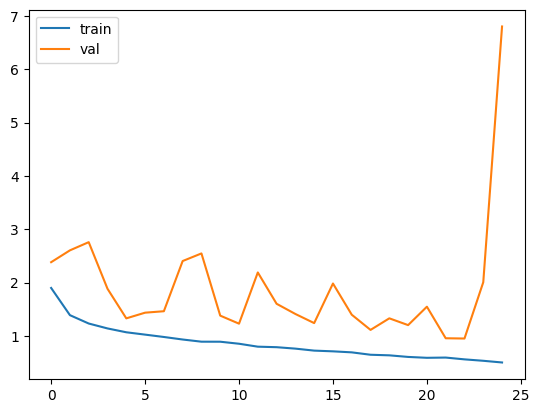

In [19]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

In [20]:
val_loss, val_acc = evaluate(
    model=model,
    dataloader=val_loader,
    criterion=criterion,
    device=device
)
test_loss, test_acc = evaluate(
    model=model,
    dataloader=test_loader,
    criterion=criterion,
    device=device
)
print(f'Val loss: {val_loss: .4f} Val acc: {val_acc: .4f}')
print(f'Test loss: {test_loss: .4f} Test acc: {test_acc: .4f}')

Val loss:  6.8022 Val acc:  0.3117
Test loss:  6.6511 Test acc:  0.3304


In [ ]:
from datetime import datetime

# Save the model weights
save_path = './models'
os.makedirs(save_path, exist_ok=True)
timestamp = datetime.now().strftime('%d-%m_%H-%M')

# Save the best model based on validation loss
best_epoch = np.argmin(val_losses)
best_model_path = f'{save_path}/weather_classification_best_epoch{best_epoch+1}.pt'
torch.save(model.state_dict(), best_model_path)
print(f"Best model saved at epoch {best_epoch+1} with validation loss: {val_losses[best_epoch]:.4f}")

# Save the final model
final_model_path = f'{save_path}/weather_classification_final.pt'
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved at {final_model_path}")